In [1]:
%matplotlib inline
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
import pandas as pd

import cv2

import keras
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.constraints import maxnorm
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D, Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
# Hight and width of the images
IMAGE_WIDTH = 124
IMAGE_HEIGHT = 20
# 1 channel
CHANNELS = 1
# Number of epochs
NUM_EPOCH = 5
# learning rate
LEARN_RATE = 1.0e-4

In [3]:
root_dir = os.path.abspath('../data')
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')
csv_file = 'keys.csv'
# check for existence
os.path.exists(train_dir)
os.path.exists(test_dir)

True

In [4]:
train = pd.read_csv(os.path.join(train_dir, csv_file))
test = pd.read_csv(os.path.join(test_dir, csv_file))

train.head()

,key,image
0,0,9
1,0,10
2,0,11
3,0,12
4,0,13


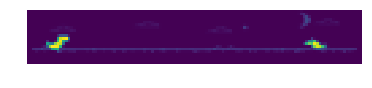

In [5]:
filepath = os.path.join(train_dir, 'snaps', str(train.iat[1100,1]) )

image = cv2.imread(filepath)
image = cv2.cvtColor( image, cv2.COLOR_RGB2GRAY )
plt.axis("off")
plt.imshow(image)
plt.show()

In [6]:
image.shape

(20, 124)

In [7]:
temp = []
for img_name in train.image:
    image_path = os.path.join(train_dir, 'snaps', str(img_name) )
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image.astype('float32')
    temp.append(image)
    
train_x = np.stack(temp)

train_x /= 255.0
train_x = train_x.reshape(-1, 20, 124, 1).astype('float32')

In [8]:
train_y = keras.utils.np_utils.to_categorical(train.key.values)

In [9]:
train_y

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       ..., 
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.]])

In [10]:
temp = []
for img_name in test.image:
    image_path = os.path.join(test_dir, 'snaps', str(img_name) )
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image.astype('float32')
    temp.append(image)
    
test_x = np.stack(temp)

test_x /= 255.0
test_x = test_x.reshape(-1, 20, 124, 1).astype('float32')

In [11]:
test_y = keras.utils.np_utils.to_categorical(test.key.values)

In [12]:
train_x.shape

(1904, 20, 124, 1)

In [13]:
def plot_model(model_details):

    # Create sub-plots
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_details.history['acc'])+1),model_details.history['acc'])
    axs[0].plot(range(1,len(model_details.history['val_acc'])+1),model_details.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_details.history['acc'])+1),len(model_details.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Summarize history for loss
    axs[1].plot(range(1,len(model_details.history['loss'])+1),model_details.history['loss'])
    axs[1].plot(range(1,len(model_details.history['val_loss'])+1),model_details.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_details.history['loss'])+1),len(model_details.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    
    # Show the plot
    plt.show()


In [14]:
def pure_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)))    
    model.add(Dropout(0.2))
    
    model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same'))  
    model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2))    
    model.add(Dropout(0.5))
    
    model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))    
    model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))
    model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2))    
    model.add(Dropout(0.5))    
    
    model.add(Conv2D(192, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (1, 1),padding='valid'))
    model.add(Activation('relu'))
    model.add(Conv2D(3, (1, 1), padding='valid'))

    model.add(GlobalAveragePooling2D())
    
    model.add(Activation('softmax'))

    model.summary()
    
    return model

In [15]:
model = pure_cnn_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 124, 96)       960       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 124, 96)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 124, 96)       83040     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 62, 96)        83040     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 62, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 62, 192)       166080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 62, 192)       331968    
__________

In [16]:
checkpoint = ModelCheckpoint('best_model_improved.h5',  # model filename
                             monitor='val_loss', # quantity to monitor
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor 

In [17]:
model.compile(loss='categorical_crossentropy', # Better loss function for neural networks
              optimizer=Adam(lr=LEARN_RATE), # Adam optimizer with 1.0e-4 learning rate
              metrics = ['accuracy']) # Metrics to be evaluated by the model

In [18]:
from sklearn.utils import class_weight

In [19]:
class_weight = class_weight.compute_class_weight('balanced', np.unique(train.key.values), train.key.values)
class_weight

array([ 0.42825011,  2.32478632,  4.25950783])

In [20]:
model_details = model.fit(train_x, train_y,
                    batch_size = 32,
                    epochs = NUM_EPOCH, # number of iterations
                    validation_data= (test_x, test_y),
                    callbacks=[checkpoint],
                    class_weight = class_weight,
                    verbose=1)

Train on 1904 samples, validate on 1102 samples
Epoch 1/5
1904/1904 [==============================] - 87s - loss: 0.8088 - acc: 0.7658 - val_loss: 0.6956 - val_acc: 0.7686
Epoch 2/5
1904/1904 [==============================] - 73s - loss: 0.6866 - acc: 0.7784 - val_loss: 0.6738 - val_acc: 0.7686
Epoch 3/5
1904/1904 [==============================] - 73s - loss: 0.6793 - acc: 0.7784 - val_loss: 0.7015 - val_acc: 0.7686
Epoch 4/5
1904/1904 [==============================] - 73s - loss: 0.6789 - acc: 0.7784 - val_loss: 0.6753 - val_acc: 0.7686
Epoch 5/5
1904/1904 [==============================] - 73s - loss: 0.6772 - acc: 0.7784 - val_loss: 0.6658 - val_acc: 0.7686


In [21]:
scores = model.evaluate(test_x, test_y, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 76.86%


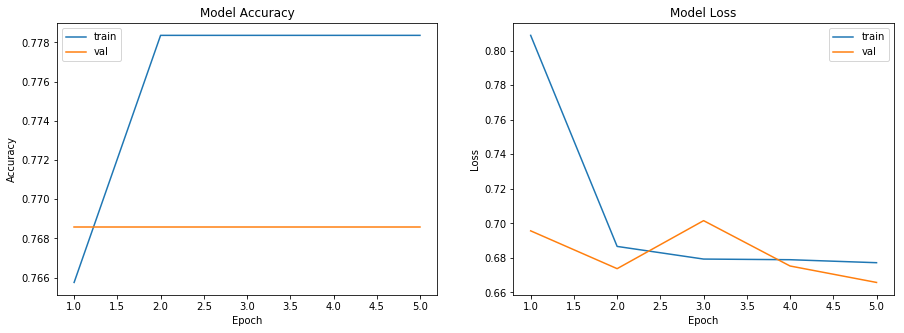

In [22]:
plot_model(model_details)